# Getting started

In this Jupyter Notebook we illustrate the core functionalities of **do mpc**.

We start by importing the required modules, most notably `do_mpc`. 

In [1]:
import numpy as np

# Add to path:
import sys
sys.path.append('../../')

# Import do_mpc package:
import do_mpc

from IPython.core.display import SVG

One of the essential paradigms of **do mpc** is a modular architecture, where individual building bricks can be used independently our jointly, depending on the application. 

This modular architecture is showcased in the flow chart below.

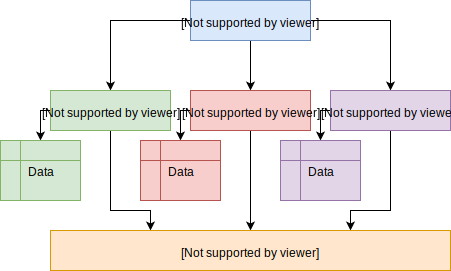

In [2]:
SVG(filename='./static/do_mpc_flowchart.svg')

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`. 

## Example system

First, we introduce a simple system for which we setup **do mpc**. We want to control a triple mass spring system as depicted below:
![test](static/triple_mass_spring.png)

Three rotating discs are connected via springs and we denote their angles as $\phi_1, \phi_2, \phi_3$.
The two outermost discs are each connected to a stepper motor with additional springs. The stepper motor angles ($\phi_{m,1}$ and $\phi_{m,2}$ are used as inputs to the system. Relevant parameters of the system are the inertia $\Theta$ of the three discs, the spring constants $c$ as well as the damping factors $d$. 

The second degree ODE of this system can be written as follows:

$$
\Theta_1 \ddot{\phi}_1 = c_1 \left(\phi_1 - \phi_{m,1} \right) -c_2 \left(\phi_1 - \phi_2 \right)- d_1 \dot{\phi}_1\\
\Theta_2 \ddot{\phi}_2 = c_2 \left(\phi_2 - \phi_{1} \right) -c_3 \left(\phi_2 - \phi_3 \right)- d_2 \dot{\phi}_2\\
\Theta_3 \ddot{\phi}_3 = c_3 \left(\phi_3 - \phi_2 \right) -c_4 \left(\phi_3 - \phi_{m,2} \right)- d_3 \dot{\phi}_3
$$

## Creating the model

As indicated above, the `model` block is essential for the application of **do mpc**.
In mathmatical terms the model is defined either as a continuous ordinary differential equation (ODE), a differential algebraic equation (DAE) or a discrete equation).

In the case of an DAE/ODE we write:

$$
\frac{\partial x}{\partial t} = f(x,u,z,p)\\
0 = g(x,u,z,p)\\
y = h(x,u,z,p)
$$

We denote $x\in \mathbb{R}^{n_x}$ as the states, $u \in \mathbb{R}^{n_u}$ as the inputs, $z\in \mathbb{R}^{n_z}$ the algebraic states and $p \in \mathbb{R}^{n_p}$ as parameters.

We reformulate the second order ODEs above as the following first order ODEs, be introducing the following states:

$$
x_1 = \phi_1\\
x_2 = \phi_2\\
x_3 = \phi_3\\
x_4 = \dot{\phi}_1\\
x_5 = \dot{\phi}_2\\
x_6 = \dot{\phi}_3\\
$$

and derive the right-hand-side function $f(x,u,z,p)$ as:

$$
\dot{x}_1 = x_4\\
\dot{x}_2 = x_5\\
\dot{x}_3 = x_6\\
\dot{x}_4 = \frac{c_1}{\Theta_1} \left(x_1 - u_1 \right) -\frac{c_2}{\Theta_1} \left(x1 - x_2 \right)- \frac{d_1}{\Theta_1} x_4\\
\dot{x}_5 = \frac{c_2}{\Theta_2} \left(x_2 - x_1 \right) -\frac{c_3}{\Theta_2} \left(x_2 - x_3 \right)- \frac{d_2}{\Theta_2} x_5\\
\dot{x}_6 = \frac{c_3}{\Theta_3} \left(x_3 - x_2 \right) -\frac{c_4}{\Theta_3} \left(x_4 - u_2 \right)- \frac{d_3}{\Theta_3} x_6\\
$$

With this theoretical background we can start configuring the **do mpc** `model` object.

First, we need to decide on the model type. For the given example, we are working with a continuous model.

In [3]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model(model_type)

### Model variables

The next step is to define the model variables. It is important to define the variable type, name and optionally shape (default is scalar variable). The following types are available:

|Long name  |                short name | Remark         |
|-----------|---------------------------|----------------|
|``states`` |                  ``_x``   |    Required    |
|``inputs`` |                  ``_u``   |    Required    |
|``algebraic``  |              ``_z``   |    Optional    |
|``parameter``  |              ``_p``   |    Optional    |
|``timevarying_parameter`` |   ``_tvp`` |    Optional    |


In [4]:
phi_1 = model.set_variable(var_type='_x', var_name='phi_1', shape=(1,1))
phi_2 = model.set_variable(var_type='_x', var_name='phi_2', shape=(1,1))
phi_3 = model.set_variable(var_type='_x', var_name='phi_3', shape=(1,1))
# Variables can also be vectors:
dphi = model.set_variable(var_type='_x', var_name='dphi', shape=(3,1))

phi_m_1 = model.set_variable(var_type='_u', var_name='phi_m_1')
phi_m_2 = model.set_variable(var_type='_u', var_name='phi_m_2')

Note that `model.set_variable()` returns the symbolic variable:

In [5]:
print('phi_1={}, with phi_1.shape={}'.format(phi_1, phi_1.shape))
print('dphi={}, with dphi.shape={}'.format(dphi, dphi.shape))

phi_1=phi_1, with phi_1.shape=(1, 1)
dphi=[dphi_0, dphi_1, dphi_2], with dphi.shape=(3, 1)


### Model parameters

Next we **define parameters**. Known values can and should be hardcoded but with robust MPC in mind, we define uncertain parameters explictly. We assume that the inertia is such an uncertain parameter and hardcode the spring constant and friction coefficient.

In [6]:
# As shown in the table above, we can use Long names or short names for the variable type.
Theta_1 = model.set_variable('parameter', 'Theta_1') 
Theta_2 = model.set_variable('parameter', 'Theta_2')
Theta_3 = model.set_variable('parameter', 'Theta_3')

c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5

### Right-hand-side equation
Finally, we set the right-hand-side of the model by calling `model.set_rhs(var_name, expr)` with the `var_name` from the state variables defined above and an expression in terms of $x, u, z, p$. 

In [7]:
model.set_rhs('phi_1', dphi[0])
model.set_rhs('phi_2', dphi[1])
model.set_rhs('phi_3', dphi[2])

For the vector valued state `dphi` we need to concatenate symbolic expressions. We import the symbolic library CasADi: 

In [8]:
from casadi import *

In [9]:
dphi_next = vertcat(
    c[0]/Theta_1*(phi_1-phi_m_1)-c[1]/Theta_1*(phi_1-phi_2)-d[0]/Theta_1*dphi[0],
    c[1]/Theta_2*(phi_2-phi_1)-c[2]/Theta_2*(phi_2-phi_3)-d[1]/Theta_2*dphi[1],
    c[2]/Theta_3*(phi_3-phi_2)-c[3]/Theta_3*(phi_3-phi_m_2)-d[2]/Theta_3*dphi[2],
)

model.set_rhs('dphi', dphi_next)

The model setup is completed by calling `model.setup_model()`:

In [10]:
model.setup_model()

After calling `model.setup_model()` we cannot define further variables etc.

## Configuring the Optimizer
With the configured and setup model we can now create the optimizer for Model Predictive Control (MPC). We start by creating the object (with the `model` as the only input)

In [11]:
optimizer = do_mpc.optimizer(model)

### Optimizer parameters

Next, we need to parametrize the `optimizer`. Please see the API documentation for `optimizer.set_param()` for a full description of available parameters and their meaning. Many parameters already have suggested default values. Most importantly, we need to set `n_horizon` and `t_step`. We also choose `n_robust=1` for this example, which would default to `0`.

Note that by default the continuous system is discretized with `collocation`.

In [12]:
setup_optimizer = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 1,
}
optimizer.set_param(**setup_optimizer)

### Objective function
The MPC formulation is at its core an optimization problem for which we need to define an objective function. 

The full optimization problem is given below:

$$
\min_{x,u,z}\quad \sum_{k=0}^{n-1}\left( \underbrace{m(x_k,u_k,z_k,p)}_{\text{meyer term}} 
+ \underbrace{\Delta u_k^T R \Delta u_k}_{\text{r-term}}\right) 
+ \underbrace{l(x_n)}_{\text{lagrange term}} 
$$

We need to define the meyer term (`mterm`) and lagrange term (`lterm`). For the given example we set:

$$
m(x_k,u_k,z_k,p) = \sum x_k^2\\
m(x_n) = \sum x_n^2
$$

In [13]:
mterm = phi_1**2 + phi_2**2 + phi_3**2 + dphi[0]**2 + dphi[1]**2 + dphi[2]**2
lterm = phi_1**2 + phi_2**2 + phi_3**2 + dphi[0]**2 + dphi[1]**2 + dphi[2]**2

optimizer.set_objective(mterm=mterm, lterm=lterm)

Part of the objective function is also the penality for the control inputs. This penalty can often be used to *smoothen* the obtained optimal solution and is an important tuning parameter. We add a quadratic penalty on changes:

$$
\Delta u_k = u_k - u_{k-1}
$$

we automatically supply the solver with the previous solution of $u_{k-1}$ for $\Delta u_0$.

The user can set the tuning factor for these quadratic terms like this:

In [16]:
optimizer.set_rterm(
    phi_m_1=1e-3,
    phi_m_2=1e-3
)

where the keyword arguments refer to the previously defined input names.

### Constraints
It is an important feature of MPC to be able to set constraints on inputs and states. In **do mpc** these constraints are set like this:

In [20]:
# Lower bounds (lb) on states:
optimizer._x_lb['phi_1'] = -2*np.pi
optimizer._x_lb['phi_2'] = -2*np.pi
optimizer._x_lb['phi_3'] = -2*np.pi
# Upper bounds (ub) on states:
optimizer._x_ub['phi_1'] = 2*np.pi
optimizer._x_ub['phi_2'] = 2*np.pi
optimizer._x_ub['phi_3'] = 2*np.pi

# Lower bounds (lb) on inputs:
optimizer._u_lb['phi_m_1'] = -2*np.pi
optimizer._u_lb['phi_m_2'] = -2*np.pi
# Upper bounds (ub) on inputs:
optimizer._u_ub['phi_m_1'] = 2*np.pi
optimizer._u_ub['phi_m_2'] = 2*np.pi

### Uncertain Parameters
An important feature of **do mpc** is scenario based robust MPC. Instead of predicting and controlling a single future trajectory, we investigate multiple possible trajectories depending on different uncertain parameters. These parameters were previously defined in the model (the mass inertia). Now we must provide the optimizer with different possible scenarios. 

This can be done in the following way:

In [21]:
inertia_mass_1 = 2.25*1e-4*np.array([1., 1.1, 0.9])
inertia_mass_2 = 2.25*1e-4*np.array([1., 1.1, 0.9])
inertia_mass_3 = 2.25*1e-4*np.array([1.])

optimizer.set_uncertainty_values([inertia_mass_1, inertia_mass_2, inertia_mass_3])

We provide a list to the method `optimizer.set_uncertain_parameter()`, where each entry is a `numpy.ndarray` with the possible values. The first value is the nominal case, where further values will lead to an increasing number of scenarios. Since we investigate each combination of possible parameters, the number of scenarios is growing rapidly. For our example, we are therefore only treating the inertia of mass 1 and 2 as uncertain and supply only one possible value for the mass of inertia 3.